<a href="https://colab.research.google.com/github/Tony5t4rk/ML-2021-Spring/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 3 - Convolutional Neural Network**

Author: Yang Liu

Study notes：[機器學習2021 学习笔记-CNN & Self-Attention](https://www.wolai.com/tony5t4rk/jFYeVKmHKnfwJyLEK18Gbh)

This program is modified based on [Sample Code](https://colab.research.google.com/github/ga642381/ML2021-Spring/blob/main/HW03/HW03.ipynb)。

# Show GPU

In [165]:
!nvidia-smi

Sat May 15 11:15:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    39W / 300W |   7657MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import Package

In [166]:
import numpy as np
import os
import gc
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, ConcatDataset, DataLoader
from torchvision.datasets import DatasetFolder

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# set a random seed for reproducibility
my_seed = 42096
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(my_seed)
torch.manual_seed(my_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(my_seed)

# Download Data from Google Drive

In [167]:
!rm -rf ./sample_data

if not os.path.exists('food-11.zip'):
    !gdown --id '1awF7pZ9Dz7X1jn1_QAiKN-_v56veCEKy' --output food-11.zip
if not os.path.exists('food-11'):
    !unzip -q food-11.zip

!apt-get -qq install -y tree
!tree -L 2

train_path = 'food-11/training'
val_path = 'food-11/validation'
test_path = 'food-11/testing'

.
├── drive
│   └── MyDrive
├── food-11
│   ├── testing
│   ├── training
│   └── validation
├── food-11.pred.csv
├── food-11.zip
├── Learning curve of CNN Model.svg
├── Learning curve of ResNet-152 Model.svg
└── models
    └── model.pth

7 directories, 5 files


# Plot Utility

In [168]:
def plot_learning_curve(loss_record, title=''):
    n_epochs = len(loss_record['train'])
    x_1 = range(n_epochs)
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_1, loss_record['val'], c='tab:cyan', label='val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.savefig('Learning curve of {}.svg'.format(title))
    plt.show()

# Hyper-Parameters

In [169]:
os.makedirs('models', exist_ok=True)

config = {
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'n_epochs': 80,
    'batch_size': 64,
    'optim_hparams': {
        'lr': 0.001,
        # 'weight_decay': 0.00001
    },
    'scheduler': {
        'mode': 'max',
        'factor': 0.5,
        'patience': 8,
        'threshold_mode': 'abs',
        'cooldown': 3,
        'min_lr': 0.000005,
        'verbose': True
    },
    'do_semi': False,
    'semi_threshold': 0.98,
    'early_stop': False,
    'early_stop_epochs': 10,
    'best_model': False,
    'model_path': 'models/model.pth',
    'pred_file': 'food-11.pred.csv'
}

print(f'device: {config["device"]}')

device: cuda


# Data Process

## Pre-Process

In [170]:
preprocess = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Dataset

In [171]:
train_dataset = DatasetFolder('food-11/training/labeled', loader=lambda x: Image.open(x).convert('RGB'), extensions='jpg', transform=preprocess)
unlabeled_dataset = DatasetFolder('food-11/training/unlabeled', loader=lambda x: Image.open(x).convert('RGB'), extensions='jpg', transform=preprocess)
val_dataset = DatasetFolder('food-11/validation', loader=lambda x: Image.open(x).convert('RGB'), extensions='jpg', transform=preprocess)
test_dataset = DatasetFolder('food-11/testing', loader=lambda x: Image.open(x).convert('RGB'), extensions="jpg", transform=preprocess)

In [172]:
class Pseudo_Subset(Dataset):
    def __init__(self, dataset, indices, labels):
        self.dataset = dataset
        self.indices = indices
        self.labels = labels

    def __getitem__(self, idx):
        return self.dataset[self.indices[idx]][0], self.labels[idx]

    def __len__(self):
        return len(self.indices)

## DataLoader

In [173]:
train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

# Model

In [174]:
class Net(nn.Module):
    def __init__(self, p=0):
        super(Net, self).__init__()

        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1), # (3, 128, 128) -> (64, 128, 128)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0), # (64, 128, 128) -> (64, 64, 64)
            nn.Dropout2d(p=p),

            nn.Conv2d(64, 128, 3, 1, 1), # (64, 64, 64) -> (128, 64, 64)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0), # (128, 64, 64) -> (128, 32, 32)
            nn.Dropout2d(p=p),

            nn.Conv2d(128, 256, 3, 1, 1), # (128, 32, 32) -> (256, 32, 32)
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0), # (256, 32, 32) -> (256, 16, 16)
            nn.Dropout2d(p=p),

            nn.Conv2d(256, 512, 3, 1, 1), # (256, 16, 16) -> (512, 16, 16)
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0), # (512, 16, 16) -> (512, 8, 8)
            nn.Dropout2d(p=p),

            nn.Conv2d(512, 512, 3, 1, 1), # (512, 8, 8) -> (512, 8, 8)
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0), # (512, 8, 8) -> (512, 4, 4)
            nn.Dropout2d(p=p),

            nn.Flatten(),
            
            nn.Linear(512 * 4 * 4, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(p=p),

            nn.Linear(2048, 11),
            nn.BatchNorm1d(11)
        )
    
    def forward(self, x):
        return self.net(x)

model = Net().to(config['device'])

# Training

In [175]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), **config['optim_hparams'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, **config['scheduler'])

In [176]:
def get_pseudo_labels(dataset, model, threshold):
    dataloader = DataLoader(dataset, batch_size=config['batch_size'], shuffle=False)
    model.eval()
    softmax = nn.Softmax(dim=-1)
    indice = 0
    indices, labels = [], []
    for x, _ in dataloader:
        x, _ = x.to(config['device']), _.to(config['device'])
        with torch.no_grad():
            logits = model(x)
        probs = softmax(logits)
        for prob in probs:
            if torch.max(probs) >= threshold:
                indices.append(indice)
                labels.append(torch.argmax(prob).item())
            indice += 1
    return Pseudo_Subset(dataset, indices, labels)

In [177]:
loss_record = {'train': [], 'val': []}

if config['early_stop']:
    early_stop_cnt = 0

min_val_loss = float('inf')

epoch = 0
while epoch < config['n_epochs']:
    if config['do_semi']:
        pseudo_dataset = get_pseudo_labels(unlabeled_dataset, model, threshold=config['semi_threshold'])
        print(f'[ Pseudo {len(pseudo_dataset):04d}/{len(unlabeled_dataset):04d} ] on [ Epoch {epoch + 1:03d}/{config["n_epochs"]:03d} ]')
        concat_dataset = ConcatDataset([train_dataset, pseudo_dataset])
        train_dataloader = DataLoader(concat_dataset, batch_size=config['batch_size'], shuffle=True)

    model.train()
    train_loss = []
    for x, y in train_dataloader:
        x, y = x.to(config['device']), y.to(config['device'])
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
    train_loss = sum(train_loss) / len(train_loss)
    loss_record['train'].append(train_loss)

    model.eval()
    val_loss = []
    for x, y in val_dataloader:
        x, y = x.to(config['device']), y.to(config['device'])
        with torch.no_grad():
            logits = model(x)
            loss = criterion(logits, y)
        val_loss.append(loss)
    val_loss = sum(val_loss) / len(val_loss)
    scheduler.step(val_loss)
    loss_record['val'].append(val_loss)

    if config['best_model']:
        if val_loss < min_val_loss:
            torch.save(model, config['model_path'])
    else:
        torch.save(model, config['model_path'])
    
    print(f'[ Epoch {epoch + 1:03d}/{config["n_epochs"]:03d} ] Train Loss: {train_loss:.5f} Valid Loss: {val_loss:.5f}')

    if config['early_stop']:
        if val_loss < min_val_loss:
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1
    
    epoch += 1
    if val_loss < min_val_loss:
        min_val_loss = val_loss

    if config['early_stop'] and early_stop_cnt > config['early_stop_epochs']:
        break

print(f'Finish Train After {epoch} Epochs')

[ Epoch 001/080 ] Train Loss: 2.03082 Valid Loss: 1.96104
[ Epoch 002/080 ] Train Loss: 1.71791 Valid Loss: 1.85886
[ Epoch 003/080 ] Train Loss: 1.56222 Valid Loss: 1.84108
[ Epoch 004/080 ] Train Loss: 1.38529 Valid Loss: 1.92233
[ Epoch 005/080 ] Train Loss: 1.22890 Valid Loss: 1.79297
[ Epoch 006/080 ] Train Loss: 1.07070 Valid Loss: 1.69575
[ Epoch 007/080 ] Train Loss: 0.81273 Valid Loss: 1.64121
[ Epoch 008/080 ] Train Loss: 0.64661 Valid Loss: 1.70574
[ Epoch 009/080 ] Train Loss: 0.47126 Valid Loss: 1.56344
Epoch    10: reducing learning rate of group 0 to 5.0000e-04.
[ Epoch 010/080 ] Train Loss: 0.37913 Valid Loss: 1.64394
[ Epoch 011/080 ] Train Loss: 0.26416 Valid Loss: 1.52435
[ Epoch 012/080 ] Train Loss: 0.23408 Valid Loss: 1.52533
[ Epoch 013/080 ] Train Loss: 0.19647 Valid Loss: 1.52552
[ Epoch 014/080 ] Train Loss: 0.18907 Valid Loss: 1.47732
[ Epoch 015/080 ] Train Loss: 0.18790 Valid Loss: 1.49743
[ Epoch 016/080 ] Train Loss: 0.16958 Valid Loss: 1.50167
[ Epoch 01

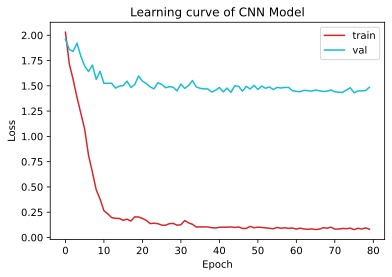

In [178]:
plot_learning_curve(loss_record, title='CNN Model')

# Testing

In [179]:
if config['best_model']:
    del model
    model = torch.load(config['model_path']).to(config['device'])

In [180]:
model.eval()

preds = []
for x, _ in test_dataloader:
    x, _ = x.to(config['device']), _.to(config['device'])
    with torch.no_grad():
        logits = model(x)
    preds.extend(logits.argmax(dim=-1).cpu().numpy().tolist())

In [181]:
print(f'Saving Result to {config["pred_file"]}')
with open(config['pred_file'], 'w') as fp:
    fp.write('Id,Category\n')
    for id, pred in enumerate(preds):
        fp.write(f'{id},{pred}\n')

Saving Result to food-11.pred.csv


In [182]:
from google.colab import drive
drive.mount('/content/drive')
!cp -r ./models '/content/drive/MyDrive/Colab/ML 2021 Spring/HW03/'
!cp ./*.pred.csv '/content/drive/MyDrive/Colab/ML 2021 Spring/HW03/'
!cp ./*.svg '/content/drive/MyDrive/Colab/ML 2021 Spring/HW03/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Result